In [64]:
# default_exp data.load_pd

In [65]:
# hide
import sys

sys.path.append("..")
import pandas as pd

In [66]:
# export
from fastseq.core import *
from fastseq.data.external import *
from fastcore.utils import *
from fastcore.imports import *
from fastai2.basics import *
from fastai2.data.transforms import *
from fastai2.tabular.core import *

In [67]:
# hide
from nbdev.showdoc import *

# Data Load Dataframe


> Using the fastai2 `Datasets` to make an time series dataset.

A multivaraite time-series dataloader. 

TODO reduce mem: https://forums.fast.ai/t/how-to-handle-dataframes-too-large-to-fit-in-memory/39208/19

In [68]:
# export
import numpy as np
import pandas as pd

In [69]:
# export
class TSMulti(MultiTuple):pass

## Transform catagorical data

In [70]:
# export
class TensorCatI(TensorBase):pass

class CatTfm(Transform):
    def __init__(self, df, cat_cols:[]): # maybe change to proccs
        self.vocab,self.o2i = {},{}
        for i, col in enumerate(L(cat_cols)):
            self.vocab[i], self.o2i[i] = uniqueify(list(df[col]), sort=True, bidir=True)
            
    def encodes(self, o:TensorCat):
        r = []
        for i in self.o2i:
            r.append(self.o2i[i][o.o[i]])            
        return TensorCatI(r, label = o._meta['label'])
    
    def decodes(self, o:TensorCatI): 
        r = []
        for i_cat in self.vocab:
            r.append(self.vocab[i_cat][o[i_cat]])
        return TensorCat(r, label = o._meta.get('label',None))
    
    

In [71]:
df = pd.DataFrame({'a':[i for i in 'aabb']})
tmf = CatTfm(df, ['a'])
o_tmf = tmf(TensorCat(['a']))
test_eq(tmf.decode(o_tmf),TensorCat(['a']))

In [72]:
df = pd.DataFrame({'a':[i for i in 'aabb'], 'a_2':[i for i in 'bccb'],})
tmf = CatTfm(df, ['a','a_2'])
o_tmf = tmf(TensorCat(['a','b']))
test_eq(tmf.decode(o_tmf),TensorCat(['a','b']))

In [73]:
# export
class TSMulti_(Tuple):pass

class CatMultiTfm(ItemTransform):
    @delegates(CatTfm.__init__)
    def __init__(self, *args, **kwargs): # maybe change to proccs
        self.f = CatTfm(*args, **kwargs)
        
    def encodes(self, o:TSMulti):
        return TSMulti_(self.f(a) for a in o)
    
    def decodes(self, o:TSMulti_): 
        return TSMulti(self.f.decode(a) for a in o)
    

In [74]:
df = pd.DataFrame({'a':[i for i in 'aabb']})
tmf = CatMultiTfm(df,'a')
print(tmf)
o = TSMulti(TensorBase([1]), TensorCat('a'))
o_tmf = tmf(o)
test_eq(o_tmf,(TensorBase([1]), TensorCatI([0])) )
o_b =tmf.decode(o_tmf)
test_eq(o_b, o)
test_eq(type(o_b), type(TSMulti(1)))

CatMultiTfm: True (TSMulti,object) -> encodes (TSMulti_,object) -> decodes


# Dataloader

In [75]:
def get_df():
    return pd.DataFrame(data={'x':[np.arange(100.),
                           np.arange(120.)],
                   'ts_0':[np.ones(100)[None,:],
                           np.ones(120)[None,:]],
                   'ts_1':[pd.Series(np.arange(100)+np.random.randn(100)),
                           pd.Series(np.arange(120)+np.random.randn(120))],
                   'var_0':[0.,1.],
                   'var_1':[2.,1.5],
                   'con_0':['a','b'],
                   'con_1':['d','c']
                       })
df = get_df()
df

,x,ts_0,ts_1,var_0,var_1,con_0,con_1
0,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0]","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]]","0 0.415920 1 1.302277 2 1.682667 3 3.554063 4 4.415546 ... 95 95.485582 96 94.652317 97 98.178709 98 98.005538 99 99.601552 Length: 100, dtype: float64",0.0,2.0,a,d
1,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, ...]","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...]]","0 1.089566 1 2.070478 2 2.367214 3 2.106791 4 5.003946 ... 115 114.653472 116 116.145638 117 116.487839 118 117.380502 119 116.031734 Length: 120, dtype: float64",1.0,1.5,b,c


In [76]:
# export
def array2series(o):
    return pd.Series(o.flatten())
def arrays2series(s:pd.Series):
    return pd.Series([array2series(o) for o in s])

In [77]:
df = pd.DataFrame(data={'x':  [np.arange(10.),
                               np.arange(12.)],
                       'ts_0':[np.ones(10)[None,:],
                               np.ones(12)[None,:]],
                       })
df['x'] = arrays2series(df['x'])
df['ts_0'] = arrays2series(df['ts_0'])
test_eq(type(df['ts_0']), pd.Series)
test_eq(type(df['x']), pd.Series)

In [78]:
# hide
df = pd.DataFrame(data={'x':  [np.arange(10.)]*100,
                       'ts_0':[np.ones(10)[None,:]]*100,
                       })
df['x'] = arrays2series(df['x'])
df['ts_0'] = arrays2series(df['ts_0'])
test_eq(type(df['ts_0']), pd.Series)
test_eq(type(df['x']), pd.Series)

In [79]:
# export
def reconize_cols(dataset):
    con_names, cat_names, ts_names, classes = L(), L(), L(), {}
    for col in dataset.columns:
        t = type(dataset[col].iloc[0])
        if t is pd.core.series.Series:
            ts_names.append(col)
        elif t is np.ndarray:
            o = arrays2series(dataset[col])
            dataset[col] = o
            ts_names.append(col)
        elif isinstance(dataset[col].iloc[0], str):
            cat_names.append(col)
            classes[col] = uniqueify(list(dataset[col].values))
        elif isinstance(dataset[col].iloc[0], float) or isinstance(dataset[col].iloc[0], int) or t is np.int64:
            con_names.append(col)
        else:
            raise Exception(t)
    return con_names, cat_names, ts_names, classes, dataset

In [80]:
# export
class PrepDF(TabularProc):
    def setup(self, dl, train_setup):
        # speed up retrival
        dl.con = dl.dataset.loc[:,dl.con_names].values.astype(float)
        dl.cat = [list(dl.dataset.loc[i,dl.cat_names]) for i in range(dl.dataset.shape[0])]
        if len(dl.ts_names):
            dl.tsx = [np.concatenate([o[None,:] for o in dl.dataset.loc[i,dl.ts_names].values]) for i in range(dl.dataset.shape[0])]
        else:
            dl.tsx = [np.empty([0,0]) for i in range(dl.dataset.shape[0])]
        assert len(dl.cat) == len(dl.tsx) == dl.con.shape[0]
        return dl

In [81]:
class test_dl(TfmdDL):    
    def __init__(self, dataset:pd.DataFrame, y_name ):
        self.con_names, self.cat_names, self.ts_names, self.classes, self.dataset = reconize_cols(dataset)     
        assert y_name in self.ts_names, {k:v for k,v in zip(['cat','con','seq'], [self.cat_names,self.con_names,self.ts_names])}
        self.ts_names.remove(y_name)
        PrepDF().setup(self, True)        
df = get_df()

dl = test_dl(df, 'x')
test_eq(dl.cat,[['a', 'd'], ['b', 'c']])
test_eq(dl.con.shape,(2,2))
test_eq(dl.tsx[0].shape, [2,100])

In [151]:
# export
@delegates()
class DfDataLoader(TfmdDL):
    def __init__(self, dataset:pd.DataFrame, y_name:str, horizon:int, lookback=72, step=1,
                 min_seq_len=None, procs = None, **kwargs):
        store_attr(self,'horizon,lookback,step,y_name')
        self.min_seq_len = ifnone(min_seq_len, lookback)
        self.dataset = dataset
        self.con_names, self.cat_names, self.ts_names, self.classes, dataset = reconize_cols(dataset)        
        assert y_name in self.ts_names, {k:v for k,v in zip(['cat','con','seq'], [self.cat_names,self.con_names,self.ts_names])}
        self.ts_names.remove(y_name)
        n = self.make_ids()
        kwargs['after_item'] = kwargs.get('after_item', CatMultiTfm(dataset, self.cat_names))
        super().__init__(dataset=self.dataset, **kwargs)
        self.n = n
        self.procs = Pipeline(PrepDF() +L(procs), as_item=True)
        self.procs.setup(self)
            

    @delegates(TfmdDL.new)
    def new(self, dataset=None, cls=None, **kwargs):
        for k,v in {k:getattr(self,k) for k in ['horizon', 'lookback', 'step']}.items():
            if k not in kwargs:
                kwargs[k] = v
        res = super().new(dataset = dataset,cls= cls, y_name= self.y_name, **kwargs)
        res.make_ids()
        return res
    
    def make_ids(self):
        """Make ids if the sequence is shorter than `min_seq_len`, it will drop that sequence."""
        # Slice each time series into examples, assigning IDs to each
        last_id = 0
        n_dropped = 0
        n_needs_padding = 0
        self._ids = {}
        for i, ts in self.dataset.iterrows(): 
            assert same_size_ts(ts, self.ts_names), f"row {i} are not all the time series the same length"
            num_examples = (ts[self.y_name].shape[-1] - self.lookback - self.horizon + self.step) // self.step
            # Time series shorter than the forecast horizon need to be dropped.
            if ts[self.y_name].shape[-1] < self.min_seq_len:
                n_dropped += 1
                continue
            # For short time series zero pad the input
            if ts[self.y_name].shape[-1] < self.lookback + self.horizon:
                n_needs_padding += 1
                num_examples = 1
            for j in range(num_examples):
                self._ids[last_id + j] = (i, j * self.step)
            last_id += num_examples

        # Inform user about time series that were too short
        if n_dropped > 0:
            print("Dropped {}/{} time series due to length.".format(
                    n_dropped, len(self.dataset)))

        # Inform user about time series that were short
        if n_needs_padding > 0:
            print("Need to pad {}/{} time series due to length.".format(
                    n_needs_padding, len(self.dataset)))
        # Store the number of training examples
        return int(self._ids.__len__() )
    
        def shuffle_fn(self, idxs):
#         self.dataset.shuffle()        
            return idxs

    def get_id(self, ts_id, lookback_id):
        if ts_id is None: raise SkipItemException()
        y = get_part_of_ts(self.dataset.loc[ts_id, self.y_name].values[None,:], lookback_id, self.lookback + self.horizon,
                           t = TensorSeqs, label=[self.y_name + '_y'], m=['g'])
        x = TensorSeqs(y[:,:self.lookback], label=[self.y_name + '_x'], m=['g'])
        if len(self.ts_names):
            tsx = get_part_of_ts(self.tsx[ts_id], lookback_id, self.lookback + self.horizon,
                                 t = TensorSeqs, label=self.ts_names)
        else: tsx = TensorSeqs(np.empty([0]), label=self.ts_names)
        r = [x, tsx]
        r.append(TensorCat(self.cat[ts_id], label=self.cat_names))
        # TODO make cat its own type
        r.append(TensorCon(self.con[ts_id,:], label=self.con_names))            
        # TODO make y its own type
        r.append(y)
        return tuple(r)

    def create_item(self, idx):
        if idx>=self.n:
            raise IndexError
        ts_id, lookback_id = self._ids[idx]
        r  = self.get_id(ts_id, lookback_id) 
        return TSMulti(r)    

The data will be stored in pandas DataFrames. This can be use for time series by nesting series into a cell. An example is shown below: 

In [122]:
df

,x,ts_0,ts_1,var_0,var_1,con_0,con_1
0,"0 0.0 1 1.0 2 2.0 3 3.0 4 4.0 ... 95 95.0 96 96.0 97 97.0 98 98.0 99 99.0 Length: 100, dtype: float64","0 1.0 1 1.0 2 1.0 3 1.0 4 1.0 ... 95 1.0 96 1.0 97 1.0 98 1.0 99 1.0 Length: 100, dtype: float64","0 -0.196158 1 0.800621 2 0.532517 3 2.656996 4 4.173639 ... 95 97.439676 96 95.536428 97 96.656181 98 98.797808 99 99.612905 Length: 100, dtype: float64",0.0,2.0,a,d
1,"0 0.0 1 1.0 2 2.0 3 3.0 4 4.0 ... 115 115.0 116 116.0 117 117.0 118 118.0 119 119.0 Length: 120, dtype: float64","0 1.0 1 1.0 2 1.0 3 1.0 4 1.0 ... 115 1.0 116 1.0 117 1.0 118 1.0 119 1.0 Length: 120, dtype: float64","0 -0.337084 1 0.569599 2 1.151948 3 2.270061 4 3.706163 ... 115 114.369365 116 119.702585 117 115.366467 118 115.987658 119 119.480632 Length: 120, dtype: float64",1.0,1.5,b,c


In [123]:
tsx = df.loc[:,['var_0', 'var_1']].values.astype(float)

In [124]:
horizon,lookback = 2,9
dl = DfDataLoader(df, 'x', horizon = horizon, lookback = lookback, num_workers=0)
def get_all():
    for o in dl:
        pass
import time
st = time.time()
get_all()
tot_time = time.time()-st
test_eq(tot_time<.6, True)
print(tot_time)

0.16161537170410156


In [125]:
horizon,lookback = 2,9
dl = DfDataLoader(df, 'x', horizon = horizon, lookback = lookback)

for o in dl:
    test_eq(type(o), TSMulti_)
    test_eq(len(o),5)
    dct = {k:v for k,v in zip(['x','tsx','cat','con','y'], o)}
    test_eq(type(o), TSMulti_)
    test_eq(dct['x'].shape[1:], (1,lookback))
    test_eq(dct['y'].shape[1:], (1,lookback+horizon))
    test_eq(dct['tsx'].shape[1:], (2,lookback+horizon))
    break
dl.classes['cat_0'] = L('a','b')

In [126]:
# hide
# without cat or con
horizon,lookback = 3,5
df = get_df()
dl = DfDataLoader(df.loc[:,['x','ts_0']], 'x', horizon = horizon, lookback = lookback)


for o in dl:
    test_eq(type(o), TSMulti_)
    test_eq(len(o),5)
    dct = {k:v for k,v in zip(['x','tsx','cat','con','y'], o)}
    test_eq(type(o), TSMulti_)
    test_eq(dct['x'].shape[1:], (1,lookback))
    test_eq(dct['y'].shape[1:], (1,lookback+horizon))
    test_eq(dct['cat'].shape[1:], ([0]))
    test_eq(dct['con'].shape[1:], ([0]))
    test_eq(dct['tsx'].shape[1:], (1,lookback+horizon))
    
test_eq(first(dl), dl.one_batch())

In [127]:
# hide
# without tsx
horizon,lookback = 3,5
df = get_df()
dl = DfDataLoader(df.loc[:, ['x','var_0','con_0']], 'x', horizon = horizon, lookback = lookback, num_workers = 0)


for o in dl:
    test_eq(type(o), TSMulti_)
    test_eq(len(o),5)
    dct = {k:v for k,v in zip(['x','tsx','cat','con','y'], o)}
    test_eq(type(o), TSMulti_)
    test_eq(dct['x'].shape[1:], (1,lookback))
    test_eq(dct['y'].shape[1:], (1,lookback+horizon))
    test_eq(dct['cat'].shape[1:], ([1]))
    test_eq(dct['con'].shape[1:], ([1]))
    test_eq(dct['tsx'].shape[1:], ([0]))
    
test_eq(first(dl), dl.one_batch())

In [128]:
# hide
# test self.new
dl.new()

# Showing

In [129]:
# export

def _show_batch_class(self, b=None, max_n=9, ctxs=None, show=True, **kwargs):
    if b is None: b = self.one_batch()
    x, y, its = self._pre_show_batch(b, max_n=max_n)
    x = self.after_item.decode(TSMulti_(x))
    if not show: return x, y, its
    show_batch(x,y,its, ctxs=ctxs, max_n=max_n, **kwargs)

DfDataLoader.show_batch = _show_batch_class

In [130]:
# export
from fastai2.vision.data import get_grid
@typedispatch
def show_batch(x:TSMulti, y:TensorSeqs, its, *args, ctxs=None, max_n=10, rows=None, cols=None, figsize=None, **kwargs):
    if ctxs is None: ctxs = get_grid(min(x[0].shape[0], max_n), add_vert=1, figsize=figsize, **kwargs)
    for i, ctx in enumerate(ctxs):  
        o = TSMulti([type(o)(o,**o._meta) for o in its[i] if o.shape[-1] > 0])
        ctx = o.show(ctx=ctx)
    return ctxs

@typedispatch
def show_batch(x:TSMulti, y:None, its, *args, ctxs=None, max_n=10, rows=None, cols=None, figsize=None, **kwargs):
    if ctxs is None: ctxs = get_grid(min(x[0].shape[0], max_n), add_vert=1, figsize=figsize, **kwargs)
    for i, ctx in enumerate(ctxs):  
        o = TSMulti([type(o)(o[i],**o[i]._meta) for o in x if o.shape[-1] > 0])
        ctx = o.show(ctx=ctx)
    return ctxs

In [131]:
show_batch

(TSMulti,NoneType) -> show_batch
(TSMulti,TensorSeqs) -> show_batch
(TSMulti,NoneType) -> show_batch
(TSMulti,TensorSeqs) -> show_batch
(TensorImage,TensorImage) -> show_batch
(TensorImage,object) -> show_batch
(Tabular,object) -> show_batch
(TensorSeq,object) -> show_batch
(object,object) -> show_batch

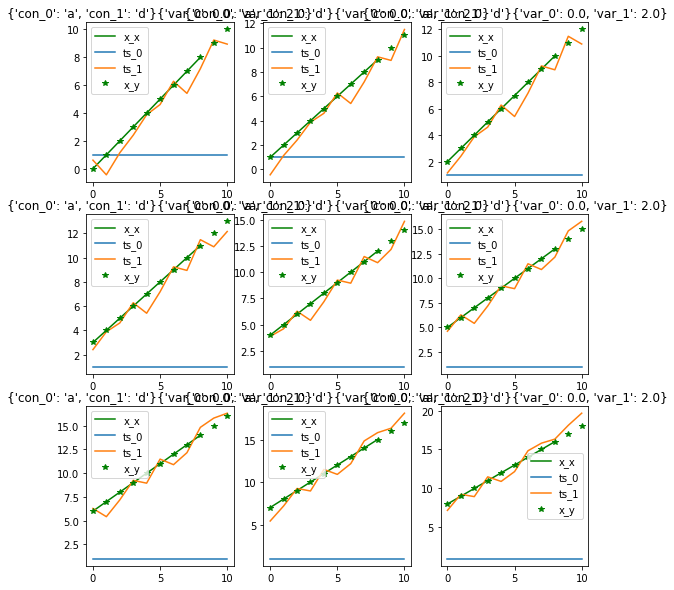

In [132]:
horizon,lookback = 2,9
df = get_df()
dl = DfDataLoader(df, 'x', horizon = horizon, lookback = lookback)
dl.show_batch()

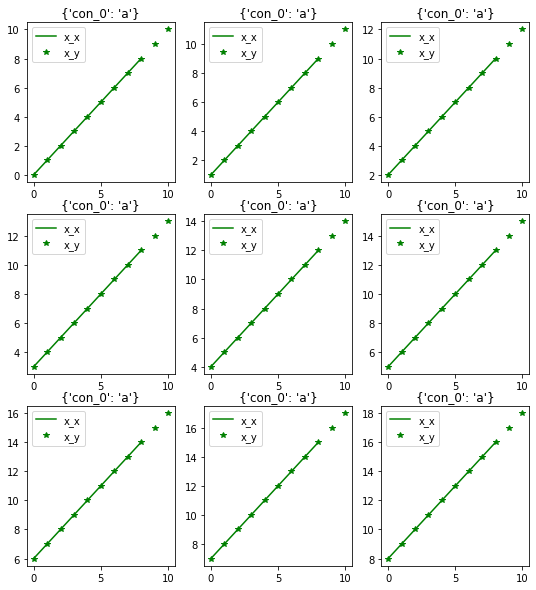

In [133]:
# hide
horizon,lookback = 2,9
df = get_df()
dl = DfDataLoader(df.loc[:,['x','con_0']], 'x', horizon = horizon, lookback = lookback)
dl.show_batch()

In [134]:
# export

# def _show_results_class(self, b, out, max_n=9, ctxs=None, show=True, **kwargs):
#     x,y,its = self.show_batch(b, max_n=max_n, show=False,)
#     x = self.after_item.decode(b)
#     b_out = b[:self.n_inp] + (tuple(out) if is_listy(out) else (out,))
#     x1,y1,outs = self.show_batch(b_out, max_n=max_n, show=False)
#     res = (x,x1,None,None) if its is None else (x, y, its, outs.itemgot(slice(self.n_inp,None)))
#     if not show: return res
#     show_results(*res, ctxs=ctxs, max_n=max_n, **kwargs)
    
# DfDataLoader.show_results = _show_results_class

In [135]:
#export
# from fastseq.data.load_pd import *

@typedispatch
def show_results(x:TSMulti, y, its, outs, ctxs=None, max_n=9,rows=None, cols=None, figsize=None, **kwargs):
    if ctxs is None: ctxs = get_grid(min(x[0].shape[0], max_n), add_vert=1, figsize=figsize, **kwargs)
    for i, ctx in enumerate(ctxs):  
        r = [type(o)(o,**o._meta) for o in its[i] if o.shape[-1] > 0] 
        r.append(type(its[i][-1])(outs[i][0], label=['pred_y'], m=['r']))
        o = TSMulti(r)        
        ctx = o.show(ctx=ctx) 


In [136]:
show_results

(TSMulti,object) -> show_results
(TSMulti,object) -> show_results
(TensorSeq,object) -> show_results
(object,object) -> show_results

In [137]:
a = TensorSeqs([0], label = ['a'])
a._meta

{'label': ['a']}

(#4) [0,19799640.0,7480778240.0,'00:00']


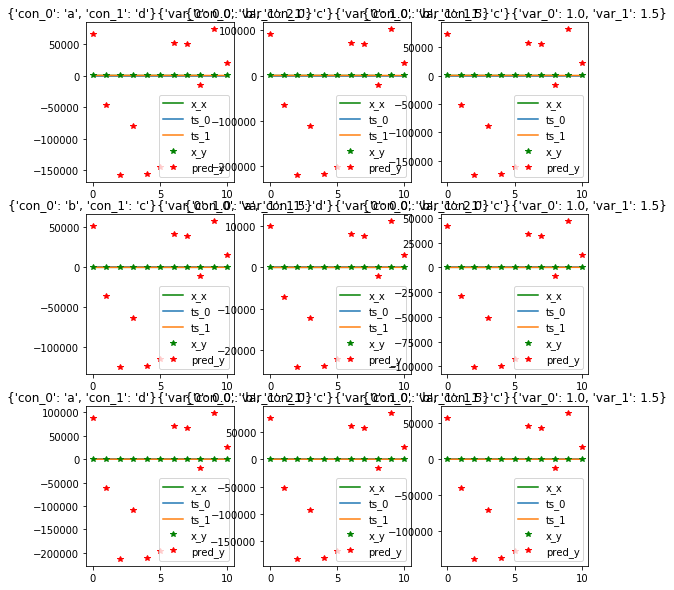

In [138]:
class RegModel(Module):
    def __init__(self, in_f, out_f): 
        self.a,self.b = nn.Parameter(torch.randn(in_f,in_f+out_f)),nn.Parameter(torch.randn(in_f+out_f))
    def forward(self, x, *args): return (torch.mm(x[:,0,:],self.a) + self.b)[:,None,:]
    
def synth_learner(lookback, horizon, cuda=False, lr=1e-3, data=None, **kwargs):
    return Learner(data, RegModel(lookback,horizon), lr=lr, loss_func=MSELossFlat(),
                   opt_func=partial(SGD, mom=0.9), **kwargs)
horizon,lookback = 2,9
dl = DfDataLoader(df, 'x', horizon = horizon, lookback = lookback)
learn = synth_learner(lookback, horizon, data=DataLoaders(dl, dl))

learn.fit(1)

learn.show_results(max_n=9)

(#4) [0,13336584.0,5038926848.0,'00:00']


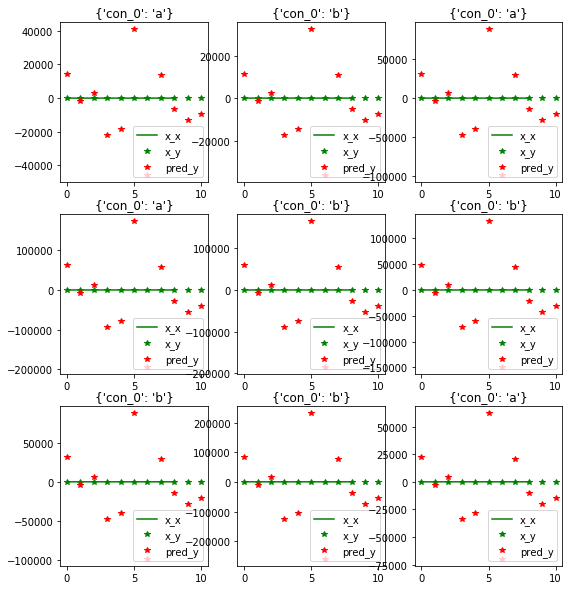

In [139]:
# hide
# wo tsx
class RegModel(Module):
    def __init__(self, in_f, out_f): 
        self.a,self.b = nn.Parameter(torch.randn(in_f,in_f+out_f)),nn.Parameter(torch.randn(in_f+out_f))
    def forward(self, x, *args): return (torch.mm(x[:,0,:],self.a) + self.b)[:,None,:]
    
def synth_learner(lookback, horizon, cuda=False, lr=1e-3, data=None, **kwargs):
    return Learner(data, RegModel(lookback,horizon), lr=lr, loss_func=MSELossFlat(),
                   opt_func=partial(SGD, mom=0.9), **kwargs)
horizon,lookback = 2,9
df = get_df()
dl = DfDataLoader(df.loc[:,['x','con_0']], 'x', horizon = horizon, lookback = lookback)
learn = synth_learner(lookback, horizon, data=DataLoaders(dl, dl))

learn.fit(1)

learn.show_results(max_n=9)

# Intergration Example

In [140]:
from fastseq.data.external import *

In [141]:
horizon,lookback = 5,10
df = dummy_data_generator_multi(32)
df['city'] = df['city']
df.head()

,x,weather,city,cont
0,"[[-0.12330214996266714, -0.7063938430084743, -0.3833658339841106, 0.0686187645332838, 1.2371862590680673, 1.1247288734700966, 0.6577813576800321, 0.8290572778323418, 1.7017597388689927, 2.2830485140340864, 1.5432958599030688, 0.10121184229492293, -0.7676110486339015, -1.1262946401772074, -0.613495690279269, -0.3595828395340604, -0.69790798673605, -0.8477913935069288, -0.9749570832881816, -0.4968777012299046, 0.5582527459142641, 0.3647681283920879, 0.17833132791285286, -0.03684125329081506, 0.8839951620363998, 1.2678853006848223, 0.7299321331634631, -0.8419059062470283, -1.3294909139179283,...","[[8.491039961066727, 7.585635050864613, 7.082607142805853, 7.828025820139947, 8.46712750235177, 7.511228239575441, 5.775211529944961, 5.56595038265946, 7.53552029582313, 9.52101596240697, 9.145909659279944, 6.844520708386908, 5.3016199128141945, 6.0549212033526665, 7.748298024052813, 8.198931797473648, 8.491039961066727, 7.585635050864613, 7.082607142805853, 7.828025820139947, 8.46712750235177, 7.511228239575441, 5.775211529944961, 5.56595038265946, 7.53552029582313, 9.52101596240697, 9.145909659279944, 6.844520708386908, 5.3016199128141945, 6.0549212033526665, 7.748298024052813, 8.1989317...",adam,0.441979
1,"[[-1.3192168882293525, -1.2899383180635677, -1.7631378815770917, -1.78154912374443, -1.1362096785095535, -0.708073668514235, -0.694391929036281, -0.20277836392280463, 0.029706165226792588, -0.27071308217219336, -0.5096407516789673, -0.5674236565762653, -0.6936198768586499, -0.37902684321833124, -0.39287571398022125, -0.10611353870746532, 0.5242284762995627, 0.6508756291188664, 0.6644416571825599, 0.6625869142305523, 0.40124218598175226, 0.49806456798636284, 0.08538171158811264, -0.09632066812038062, -0.19603505699825513, -0.21905921848463233, 0.3923387236394655, 0.5366684984377655, 1.39720...","[[9.36116202337151, 8.481891456465242, 7.567247287964961, 7.560386508041848, 8.505946758536151, 9.502934534082152, 9.622023233854703, 8.73209178847206, 7.409804028865562, 6.265366421221269, 5.573877459847447, 5.4501419434283385, 5.996924153661954, 7.0470994177334, 7.945823627616323, 7.966295646080615, 9.36116202337151, 8.481891456465242, 7.567247287964961, 7.560386508041848, 8.505946758536151, 9.502934534082152, 9.622023233854703, 8.73209178847206, 7.409804028865562, 6.265366421221269, 5.573877459847447, 5.4501419434283385, 5.996924153661954, 7.0470994177334, 7.945823627616323, 7.966295646...",adam,-1.952334
2,"[[-1.4256391342232393, -1.414937600998735, -1.0114381226147071, -0.7714978266869587, -0.6085206985004445, -0.714540258381986, -0.288087358041101, -0.14605177600014588, 0.11054930106434266, 0.1851763740809542, -0.6183712924576695, -1.207930575797237, -1.4847838483010414, -1.4825936654206613, -0.7383116962081911, -0.3537360996602633, 0.7949897253216468, 1.6200900453610307, 2.012294904366707, 2.2114647791768762, 1.8313770063053965, 0.6855180546450729, -0.11526860966594764, -0.38717633733676005, -0.05712827103860919, 0.1404766130773381, 0.1640856422489498, 0.2843834004529397, 0.371684208556348...","[[2.8237762407094666, 2.5600743840393863, 3.111978455031724, 3.7310790896360917, 3.003974741019098, 0.9767520382717065, -0.49200560559941575, 0.11324341758246037, 2.0318795008870416, 3.1009973372853312, 2.356764308680776, 1.0248311380406099, 0.7462687135785938, 1.5240203871285947, 2.0605975690594707, 1.7676606292301176, 2.8237762407094666, 2.5600743840393863, 3.111978455031724, 3.7310790896360917, 3.003974741019098, 0.9767520382717065, -0.49200560559941575, 0.11324341758246037, 2.0318795008870416, 3.1009973372853312, 2.356764308680776, 1.0248311380406099, 0.7462687135785938, 1.524020387128...",adam,-1.543751
3,"[[0.11092066636465803, 0.09856381156048884, -0.021432079439287197, 0.3317897790289497, 0.5223273540459494, 0.8266830487508973, 1.1639936353076072, 1.4060497558581289, 2.059684339255227, 1.8051229999383183, 0.45250396353167766, -0.48678603541586163, -0.6533753389527224, -0.5791480795225774, 0.5109457060360157, 0.7

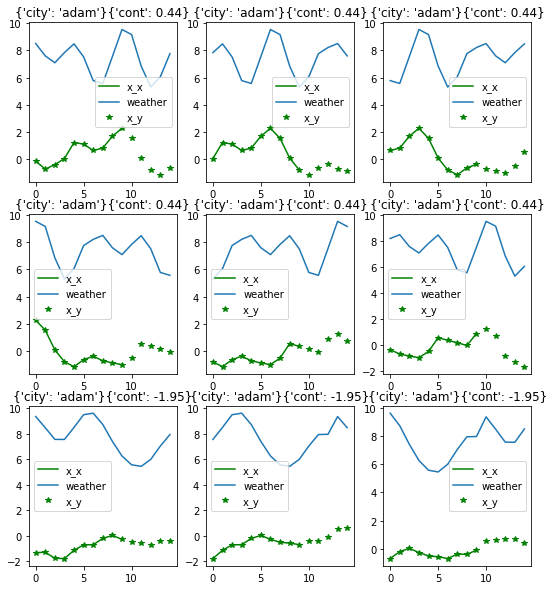

In [142]:
dl = DfDataLoader(df, 'x', horizon = horizon, lookback = lookback, step=3, bs=32)
dl.show_batch(max_n=9)

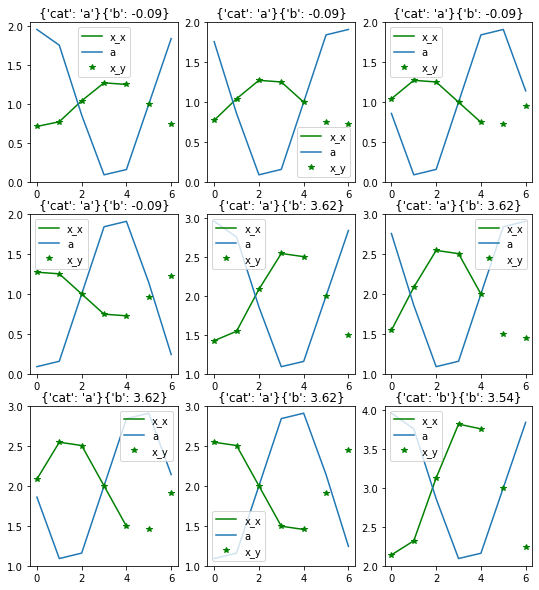

In [143]:
# hide
from fastseq.data.load import *
horizon,lookback = 2,5
t = np.arange(-5,5.)
a = np.sin(t)
df = pd.DataFrame({'x':[i + (i*.6)*a*-.5 for i in range(1,5)],
                   'a':[i+a for i in range(1,5)],
                   'b':[i+torch.randn(1).numpy()[0] for i in range(1,5)],
                   'cat':[i for i in 'aabb'],                  
                  })
dl = DfDataLoader(df, 'x', horizon = horizon, lookback = lookback, 
#                   after_batch = NormalizeTSMulti(),
                  num_workers = 1)
dl.show_batch()

# M5 Example

In [144]:
path = Path('../data/m5_tiny')
path.ls()

(#5) [Path('../data/m5_tiny/sales_train_validation.csv'),Path('../data/m5_tiny/sample_submission.csv'),Path('../data/m5_tiny/calendar.csv'),Path('../data/m5_tiny/sales_train_preped.csv'),Path('../data/m5_tiny/sell_prices.csv')]

In [145]:
df_sales = pd.read_csv(path / 'sales_train_validation.csv',).iloc[:100,:]
df_sales.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


In [146]:
# export
def _to_series(df):
    r = []
    for i in range(df.shape[0]):
        r.append(pd.Series(df.iloc[i,6:].values.astype(float)))
    return r

def to_contained_series(df):    
    data={k:v for k,v in dict(df).items() if 'd_' not in k}
    data['sales'] = pd.Series(_to_series(df))
    df = pd.DataFrame(data=data)
    return df

In [147]:
df_sales_s = to_contained_series(df_sales)

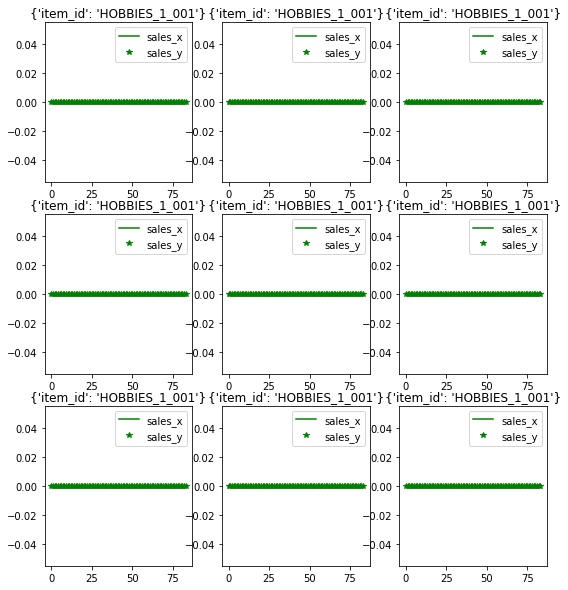

In [148]:
dl =  DfDataLoader(df_sales_s.loc[:,['sales','item_id']], 'sales', horizon = 28, lookback=28*2, step=7)
dl.show_batch(max_n=9)

In [ ]:
# hide
from nbdev.export import *
notebook2script()

Converted 00_core.ipynb.
Converted 01_data.external.ipynb.
Converted 020_data.load_pd.ipynb.
Converted 02_data.load.ipynb.
Converted 030_data.core_pd.ipynb.
Converted 03_data.core.ipynb.
